### MEC2015 - System Identification

#### Student: Felipe da Costa Pereira



Build ARMAX models for the robot arm data used previoously, with either options below (pick only one, whichever suits you best):
- R: from [4] given in the user manual (see example 2) on this link 
- Python 1: see statsmodels.tsa.arima.model.ARIMA (ARMA models with exogenous variables)
- Python 2: see sysidentpy package (ARMAX models) in the website link

Present your results in terms of FR simulation and correlation tests. Compare with the best results from ARX models obtained previoulsy.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sysidentpy.general_estimators import NARX
from sysidentpy.model_structure_selection import FROLS

from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error, mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression
from sklearn.metrics import r2_score

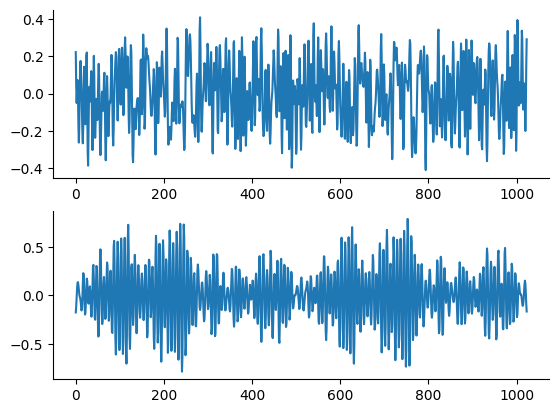

In [2]:
data = np.loadtxt('robot_arm.dat')

U=data[:,0]
Y=data[:,1]

f,ax = plt.subplots(2)
ax[0].plot(U)
ax[1].plot(Y)

Splittng data the same way as previsously (50% for parameters estimation, 50% validation)

In [3]:
utra = U[:512]
uval = U[512:]
ytra = Y[:512]
yval = Y[512:]

In order to apply the fit method, the datasets need to be reshaped

In [265]:
utra = np.reshape(utra, (-1,1))
ytra = np.reshape(ytra, (-1,1))
uval = np.reshape(uval, (-1,1))
yval = np.reshape(yval, (-1,1))
u = np.reshape(U, (-1,1))
y = np.reshape(Y, (-1,1))

Models Orders to be tested

In [266]:
orders = [2,3,4,6, 10, 15]

Main loop for a range of orders of the ARMAX model

In [268]:
# LINEAR (n=1)
basis_function_linear = Polynomial(degree=1)

# storing results
dict_ar = {
    'orders': [], 'yhat_OSA': [], 'yhat_FR': [], 'ee': [], 'r2': [], 'ue': [],
}

for order in orders:
    m_armax = NARX(
        xlag=int(order),
        ylag=int(order),
        model_type='NARMAX',
        basis_function=basis_function_linear,
        base_estimator=LinearRegression(),
    )
    m_armax.fit(X=utra, y=ytra)

    yhat_OSA_ar = m_armax.predict(X=utra, y=ytra, steps_ahead=1)    
    # yhat_FR_ar = m_armax.predict(X=uval, y=yval)
    yhat_FR_ar = m_armax.predict(X=u, y=y)

    ee_ar = compute_residues_autocorrelation(ytra, yhat_OSA_ar)
    ue_ar = compute_cross_correlation(ytra, yhat_OSA_ar, uval)
    
    # r2_ar = r2_score(yval, yhat_FR_ar)
    r2_ar = r2_score(y, yhat_FR_ar)
    
    dict_ar['orders'].append(order)
    dict_ar['yhat_OSA'].append(yhat_OSA_ar)
    dict_ar['yhat_FR'].append(yhat_FR_ar)
    dict_ar['ee'].append(ee_ar[0])
    dict_ar['ue'].append(ue_ar[0])
    dict_ar['r2'].append(r2_ar)

Main loop for a range of orders of the NARMAX model

In [269]:
# storing results
dict_nar = {
    'orders': [], 'yhat_OSA': [], 'yhat_FR': [], 'ee': [], 'r2': [], 'ue': [],
}

# testing several non linear degrees, best is 3.
print('nl', 'order', 'R2')
for nl in [3]:
    for order in orders:
        m_narmax = FROLS(
            # order_selection=False,
            # n_info_values=200,
            n_terms=15,
            extended_least_squares=True,
            ylag=int(order), xlag=int(order),elag=int(order)-1,
            estimator='least_squares',
            basis_function=Polynomial(degree=nl)
        )

        m_narmax.fit(X=utra, y=ytra)
        
        yhat_OSA_nar = m_narmax.predict(X=utra, y=ytra, steps_ahead=1)
        
        # yhat_FR_nar = m_narmax.predict(X=uval, y=yval)
        yhat_FR_nar = m_narmax.predict(X=u, y=y)

        ee_nar = compute_residues_autocorrelation(ytra, yhat_OSA_nar)
        ue_nar = compute_cross_correlation(ytra, yhat_OSA_nar, uval)
        # r2_nar = r2_score(yval, yhat_FR_nar)
        r2_nar = r2_score(y, yhat_FR_nar)
        
        print(nl, order, r2_nar);

        dict_nar['orders'].append(order)
        dict_nar['yhat_OSA'].append(yhat_OSA_nar)
        dict_nar['yhat_FR'].append(yhat_FR_nar)
        dict_nar['ee'].append(ee_nar[0])
        dict_nar['ue'].append(ue_nar[0])
        dict_nar['r2'].append(r2_nar)

nl order R2


c:\Users\bewm\AppData\Roaming\Python\env\env_sys\lib\site-packages\sysidentpy\parameter_estimation\estimators.py:114: UserWarning: Psi matrix might have linearly dependent rows.Be careful and check your data
  self._check_linear_dependence_rows(psi)


3 2 0.22241688650008906
3 3 0.6532789815832551
3 4 0.5719197430610024
3 6 0.9985886803551587
3 10 -2.1228154181691266


c:\Users\bewm\AppData\Roaming\Python\env\env_sys\lib\site-packages\sysidentpy\parameter_estimation\estimators.py:114: UserWarning: Psi matrix might have linearly dependent rows.Be careful and check your data
  self._check_linear_dependence_rows(psi)


3 15 0.9986694097734338


Plotting Results

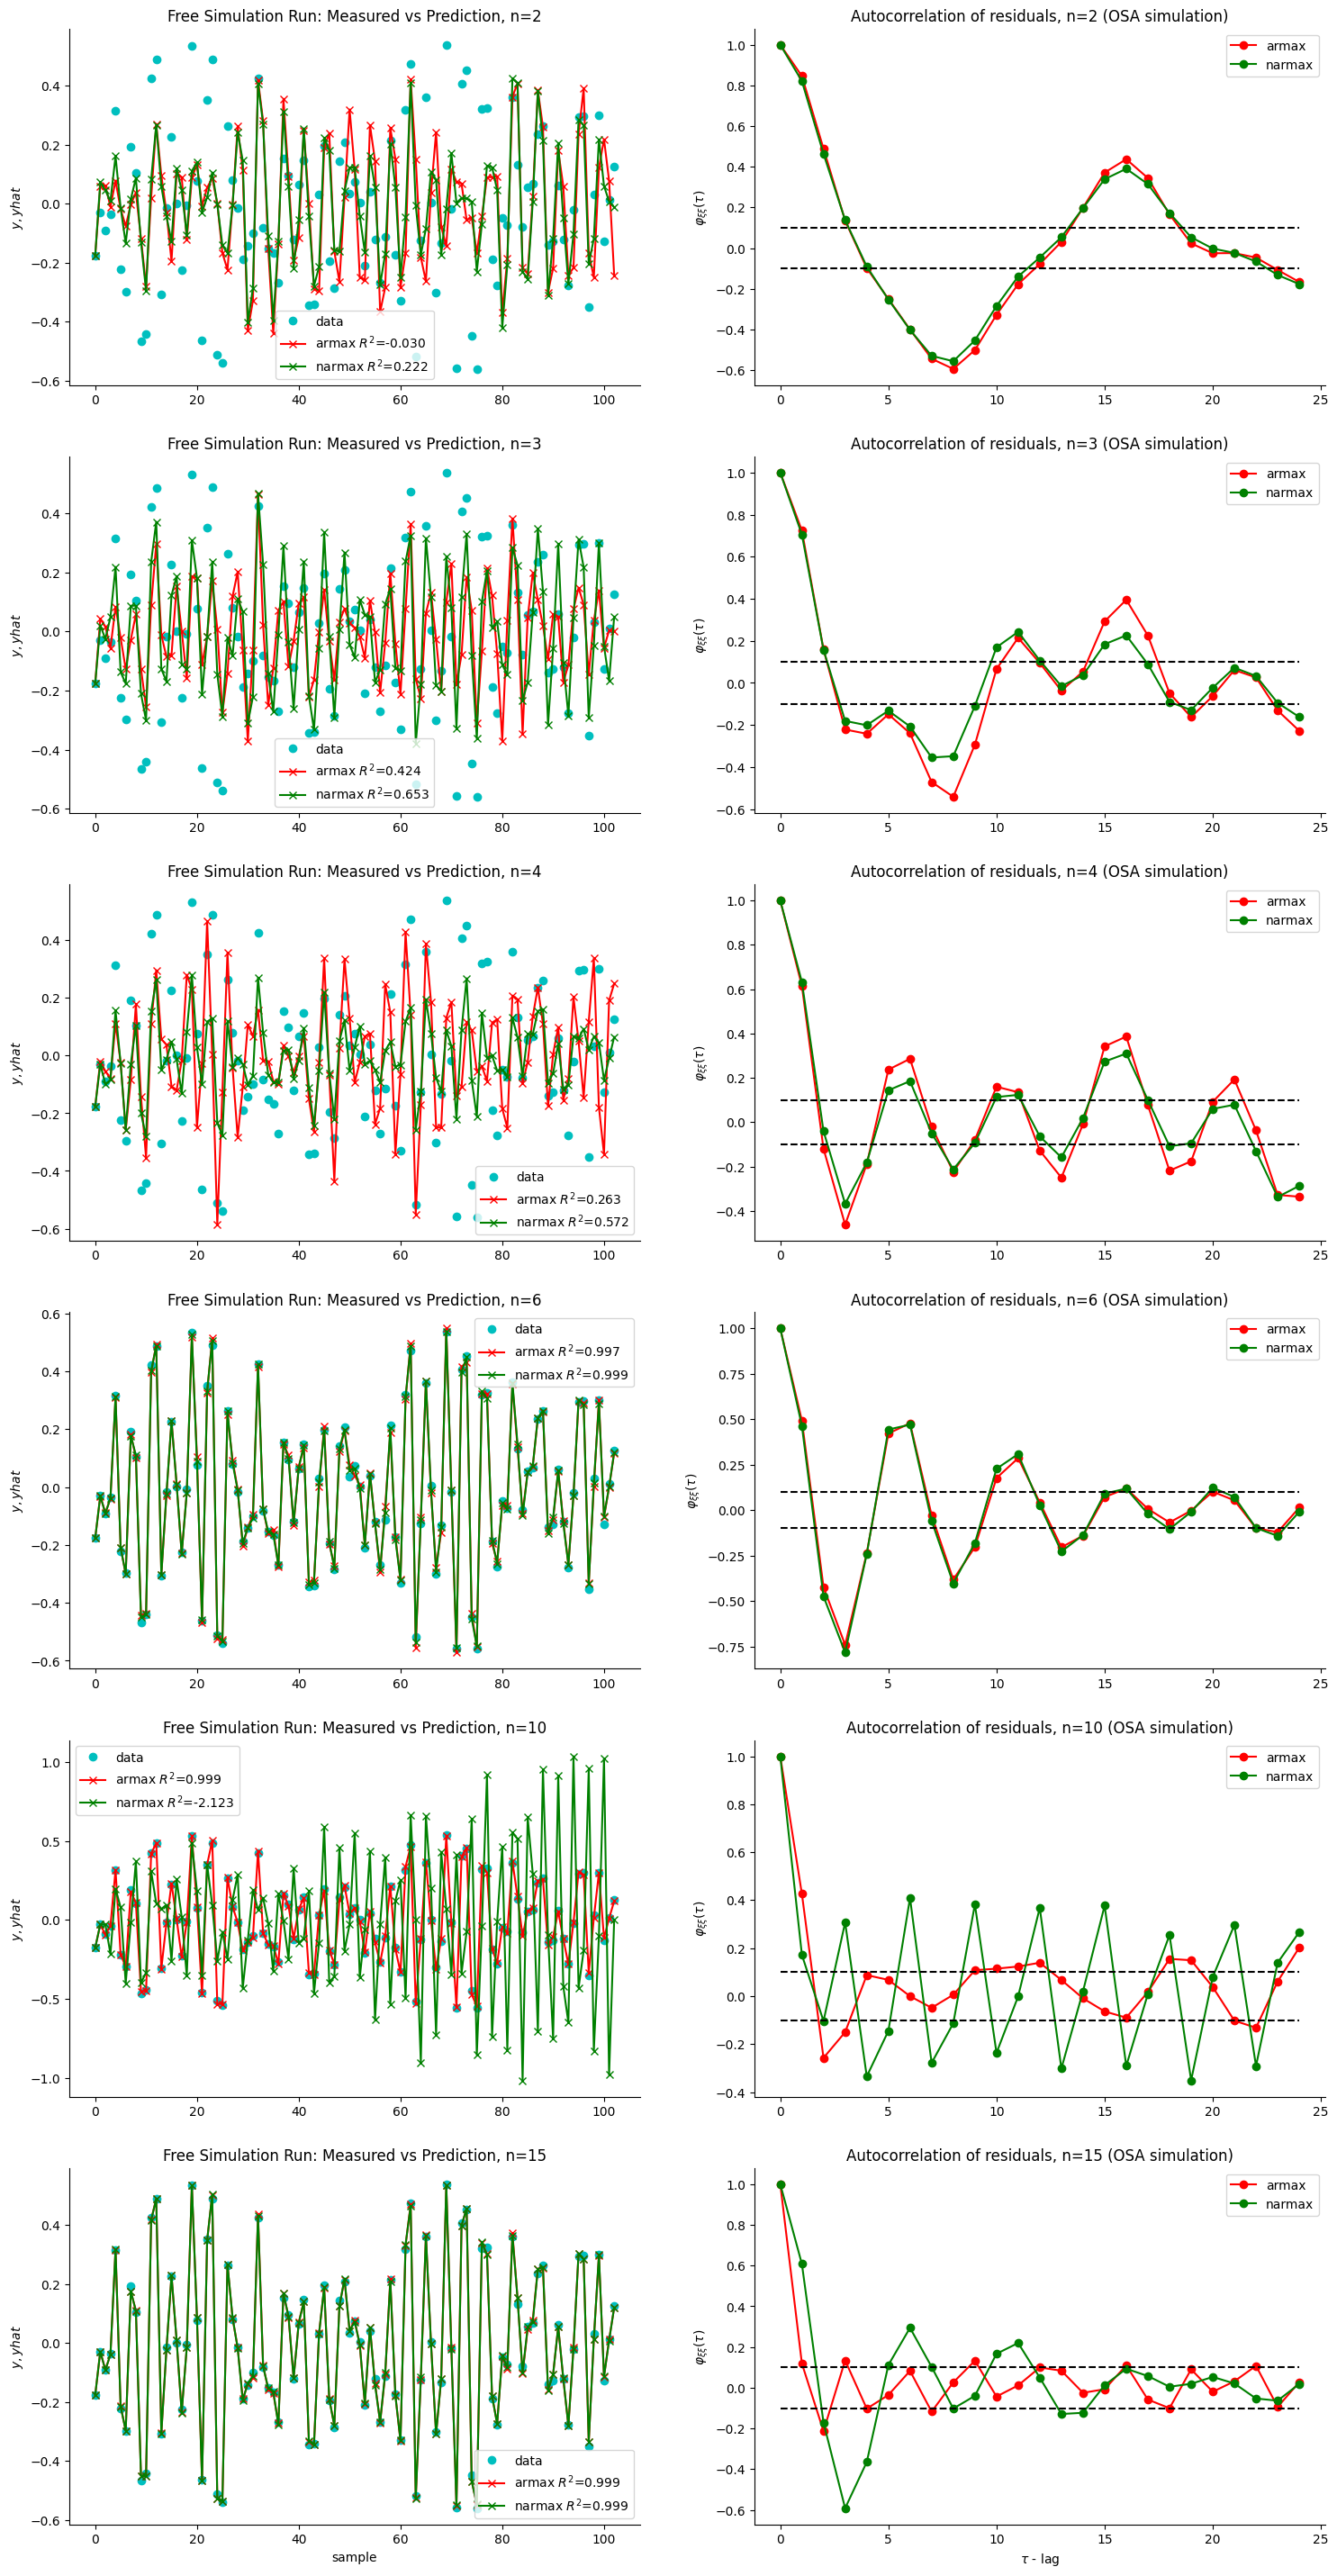

In [272]:
sample_rate = 10
autocorr_lags = 25

no = len(orders)

plt.subplots(no,2,figsize=(18,6*no))
for i,o in enumerate(orders):

    plt.subplot(no,2,2*i+1)
    r2_ar=dict_ar['r2'][i]
    r2_nar=dict_nar['r2'][i]
    plt.title(f'Free Simulation Run: Measured vs Prediction, n={o}')
    # plt.plot(yval[::sample_rate], 'o', c='k')
    plt.plot(y[::sample_rate], 'o', c='k')
    plt.plot(dict_ar['yhat_FR'][i][::sample_rate], 'x-', c='r')
    plt.plot(dict_nar['yhat_FR'][i][::sample_rate], 'x-', c='g')
    plt.legend(['data',f'armax $R^2$={r2_ar:.3f}', f'narmax $R^2$={r2_nar:.3f}'])
    plt.ylabel('$y,yhat$')
    if i==no-1:
        plt.xlabel('sample')

    plt.subplot(no,2,2*i+2)
    plt.title(f'Autocorrelation of residuals, n={o} (OSA simulation)')
    plt.plot(dict_ar['ee'][i][:autocorr_lags], 'o-', c='r')
    plt.plot(dict_nar['ee'][i][:autocorr_lags], 'o-', c='g')
    plt.plot([0.1 for i in range(autocorr_lags)], 'k--')
    plt.plot([-0.1 for i in range(autocorr_lags)], 'k--')
    plt.legend(['armax', 'narmax'])
    plt.ylabel(r'$\varphi_{\xi\xi}(\tau)$')
    if i==no-1:
        plt.xlabel(r'$\tau$ - lag')

simulcao livre com todo o conjunto
varios graus de nao linearidade (nl) testados, melhor resultado com nl=3
para ordens baixas na ,nb o modelo narmax melhora o resultado (graus 2,3,4), já pra ordens mais altas nao e evidente a melhora., maior quantidade de paramtros a serem ajustados.



Comments on the results:
- For the Free Run simulation, best results were found for the ARMAX models when comparing with the previsously trained ARX.
- For $n>=6$, the ARMAX models already present high $R^2$ scores ($R^2>0.997$). If we go back to Work 03, the ARX obtained previously had a $R^2$ score of about 50%, even for higher orders.
- Although the $R^2$ score is satisfatory for the Free Run Simulation for $n>=6$ in the ARMAX architecture, the autocorrelation tests for these models present a poor performance until $n=9$. For $n>10$, the coefficients of the autocorrelation starts to remain inside the boudaries and we considered the best model to be $n=15$, exaclty the order selected as the best on for the ARX architecture.